In [1]:
!pip install tensorflow_addons

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import sklearn as skl
import seaborn as sns
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import skew, kurtosis
from scipy.fft import fft2
from skimage.filters import gabor_kernel
from scipy import fftpack

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
#from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa

import os
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

tfk = tf.keras
tfkl = tf.keras.layers

In [3]:
#TO SAVE A DF
'''
dataframe.to_csv('/kaggle/working/dataframe_quality_laplace.csv', index=False)
'''


"\ndataframe.to_csv('/kaggle/working/dataframe_quality_laplace.csv', index=False)\n"

In [4]:
#filtering low quality ones out
dataframe = pd.read_csv('/kaggle/input/quality-annotated-dataframe/quality_annotated_dataframe.csv')
dataframe_quality = dataframe[dataframe['quality'] == 0]

filenames = dataframe_quality['file'].to_numpy()
to_remove = np.zeros(filenames.shape[0])

num_duplicates = 0

# Let's remove duplicates
for index in range(filenames.shape[0]):
    # Ignore the last element
    if index == filenames.shape[0] - 1:
        break
    
    filename = filenames[index]
    next_filename = filenames[index + 1]
    
    # Remove extension
    filename = filename.replace('.png', '')
    filename = filename.replace('.jpeg', '')
    next_filename = next_filename.replace('.png', '')
    next_filename = next_filename.replace('.jpeg', '')
    
    # If consecutive filenames refer to the same patient
    if filename[:-2] == next_filename[:-2]:
        to_remove[index + 1] = 1
        num_duplicates = num_duplicates + 1
        index = index + 1
        
dataframe_quality = dataframe_quality[to_remove == 0]
        
print('Removed %d duplicates' % num_duplicates)

dataframe_path = dataframe_quality.copy()
dataframe_path['path'] = '/kaggle/input/training-dataset/train/' + dataframe_path['label'] + '/' + dataframe_path['file']




Removed 1293 duplicates


In [5]:
dataframe_path['path'][1]

'/kaggle/input/training-dataset/train/N/P00001_2.png'

In [6]:
from sklearn.model_selection import train_test_split

seed = 3913326
train_path_based, test_path_based = train_test_split(dataframe_path,random_state = seed, test_size=0.2, shuffle=True)
train_path_based, validation_path_based = train_test_split(train_path_based, random_state=seed, test_size=0.1, shuffle=True)

In [7]:
#FUNCTIONS FOR FEATURE EXTRACTION IN FOURIER DOMAIN

# Compute the Fourier Transform of the images
def compute_fourier_coefficients(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))

    return magnitude_spectrum #coefficients



# Define function to extract features from image
def extract_features(image_fft):
    magnitude = np.abs(image_fft)
    
    
    # Shift zero-frequency component to center of spectrum
    fft_shifted = fftpack.fftshift(image_fft)
    # Compute magnitude spectrum
    mag_spectrum = np.abs(fft_shifted)
    # Compute power spectrum
    power_spectrum = mag_spectrum ** 2
    # Compute PSD
    psd = power_spectrum / np.prod(image_fft.shape)
    # Compute entropy of PSD
    psd_flatten = psd.flatten()
    psd_norm = psd_flatten / np.sum(psd_flatten)
    entropy = -np.sum(psd_norm * np.log2(psd_norm))
    
    # Compute higher-order spectral moments
    spectral_moments = []
    for order in range(2, 6):
        moment = np.sum(np.abs(fft_shifted) ** order)
        spectral_moments.append(moment)
    
    # define Gabor filter parameters
    num_orientations = 8
    num_scales = 5
# define empty list to store Gabor filter features
    gabor_features = []
# iterate over each channel of the input
    for c in range(image_fft.shape[-1]):
    # iterate over each Gabor filter
        for theta in np.linspace(0, np.pi, num_orientations, endpoint=False):
            for sigma in np.logspace(np.log10(1), np.log10(8), num_scales):
            # generate Gabor filter kernel
                kernel = np.real(gabor_kernel(frequency=0.2, bandwidth=sigma, theta=theta))
            # apply Gabor filter to the current channel
                response = cv2.filter2D(image_fft[:, :, c], -1, kernel)
            # compute mean of absolute response values
                gabor_features.append(np.mean(np.abs(response)))

    stats = [
        np.mean(magnitude),
        np.var(magnitude),
        skew(magnitude.flatten()),
        kurtosis(magnitude.flatten())
    ]

    # Combine features into a single vector
    #features = np.concatenate([stats, power_spectrum.flatten()])
    features = np.concatenate([spectral_moments, stats, gabor_features,np.array([entropy])])


    return features



In [8]:
#CUSTOM IMAGE DATA GENERATOR CLASS

class FourierImageDataGenerator(ImageDataGenerator):
    def __init__(self, fourier_preprocessing_fn=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fourier_preprocessing_fn = fourier_preprocessing_fn
    
    def preprocess_image(self, img):
        # Convert the image to Fourier domain and extract features
        if self.fourier_preprocessing_fn is not None:
            img = self.fourier_preprocessing_fn(img)
        # Apply the rest of the preprocessing steps from the parent class
        img = super().preprocess_image(img)
        return img


In [9]:
#FOURIER PREPROCESSING FUNCTION

def fourier_preprocessing(image):
    image = cv2.resize(image, (512, 512))
    if image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = np.uint8(image)

    # Check if background is Standard Radiological Format compliant, otherwise invert colors
    # (the check is performed on the median color along the spine)
    buffer = image / np.max(image)

    median_spine = np.median(buffer[:, buffer.shape[1] // 2])

    if median_spine < 0.5:
        image = cv2.bitwise_not(image)

    # Mist reduction and gamma transformation
    img_equalized = cv2.equalizeHist(image)
    gamma = 1.5
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                    for i in np.arange(0, 256)]).astype('uint8')
    img_gamma = cv2.LUT(img_equalized, table)

    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img_gamma)

    # Apply Gaussian Smoothing
    gaussian_img = cv2.GaussianBlur(clahe_img, (5,5), 0)
    gaussian_img = gaussian_img.reshape((512,512,1))
    coefficient = compute_fourier_coefficients(gaussian_img)
    feature_vec = extract_features(coefficient)
    
    
    return feature_vec

In [10]:
#Exammple of using fourier_preprocessing function

img_temp =cv2.imread("/kaggle/input/training-dataset/train/N/P00001_2.png")
ft_img_temp = fourier_preprocessing(img_temp)
print("number of features: " ,ft_img_temp.shape)


number of features:  (49,)


In [11]:
root_dir = '/kaggle/input/normalpneumoniatubeculosis-qualityannotated'
# Instantiate the FourierImageDataGenerator with the Fourier preprocessing function
fourier_generator = FourierImageDataGenerator(fourier_preprocessing_fn=fourier_preprocessing)

# Read the images from the dataframe with flow_from_dataframe
train_generator = fourier_generator.flow_from_dataframe(dataframe=train_path_based,
                                                        directory=root_dir,
                                                        x_col="path", 
                                                        y_col="label",
                                                        target_size=(1,49),
                                                        #target_size=(1,4),
                                                        batch_size=32)
'''
val_generator = fourier_generator.flow_from_dataframe(dataframe=validation_path_based,
                                                        directory=root_dir,
                                                        x_col="path", 
                                                        y_col="label",
                                                        target_size=(1,45),
                                                        #target_size=(1,4),
                                                        batch_size=32)
'''

test_generator = fourier_generator.flow_from_dataframe(dataframe=test_path_based,
                                                        directory=root_dir,
                                                        x_col="path", 
                                                        y_col="label",
                                                        target_size=(1,49),
                                                        #target_size=(1,4),
                                                        batch_size=32)

Found 7769 validated image filenames belonging to 3 classes.
Found 2159 validated image filenames belonging to 3 classes.


In [12]:
_ = next(train_generator)
#_[1][i] #labels
print("sample shape: " + str(_[0][0].shape)) #features 

sample shape: (1, 49, 3)


In [13]:
# Extract the features and labels from the train generator
features, labels = [], []
for i in range(len(train_generator)):
    batch_features, batch_labels = train_generator[i]
    features.append(batch_features.reshape(batch_features.shape[0], -1))
    labels.append(np.argmax(batch_labels, axis=1))
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

mean = np.mean(features, axis=0)
std = np.std(features, axis=0)

# Normalize the features using the mean and standard deviation
features = (features - mean) / std


In [14]:
# Extract the features and labels from the test generator
test_features, test_labels = [], []
for i in range(len(test_generator)):
    batch_features, batch_labels = test_generator[i]
    test_features.append(batch_features.reshape(batch_features.shape[0], -1))
    test_labels.append(np.argmax(batch_labels, axis=1))
test_features = np.concatenate(test_features, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

mean_test = np.mean(test_features, axis=0)
std_test = np.std(test_features, axis=0)

# Normalize the features using the mean and standard deviation
test_features = (test_features - mean_test) / std_test

In [15]:
#RF
#class_weights = {0: 0.8, 1: 1.0, 2: 3.5}
rf_model = RandomForestClassifier(n_estimators=250, max_depth=50)#, class_weight= class_weights)
rf_model.fit(features, labels)

RandomForestClassifier(max_depth=50, n_estimators=250)

In [16]:
#SVC
class_weights = {0: 0.8, 1: 1.0, 2: 3.5}
svc_model = SVC(kernel='rbf', C=40, gamma='auto',probability=True,class_weight=class_weights)
svc_model.fit(features, labels)


SVC(C=40, class_weight={0: 0.8, 1: 1.0, 2: 3.5}, gamma='auto', probability=True)

In [18]:
!pip install xgboost

In [19]:
#XGB
import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    n_estimators=400,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    class_weights=class_weights,
    colsample_bytree=0.8,
    seed=42
)

# Train the model
xgb_model.fit(features, labels)


[18:34:15] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weights" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              class_weights={0: 0.8, 1: 1.0, 2: 3.5}, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=400,
              n_jobs=0, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=42, ...)

In [20]:
rf_pred = rf_model.predict(test_features)

In [24]:
rf_pred.shape , test_labels.shape

((2159,), (2159,))

In [26]:
svc_pred = svc_model.predict(test_features)


In [28]:
xgb_pred = xgb_model.predict(test_features)

Accuracy: 0.8384
Precision: 0.8601
Recall: 0.6943
F1: 0.7204


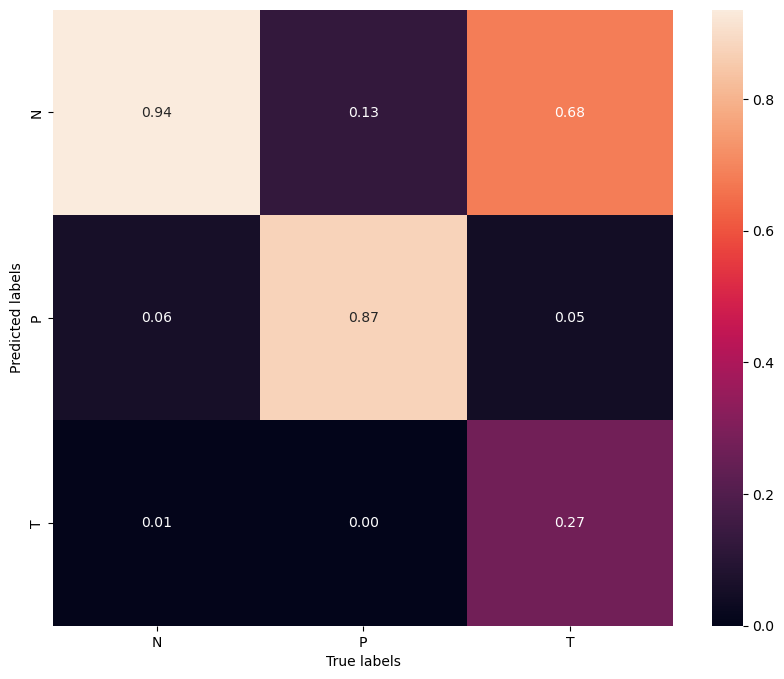

In [ ]:
#With normalization-RF
# Compute the confusion matrix
cm = confusion_matrix(test_labels, rf_pred)
cm_rel = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Compute the classification metrics
accuracy = accuracy_score(test_labels, rf_pred)
precision = precision_score(test_labels, rf_pred, average='macro')
recall = recall_score(test_labels, rf_pred, average='macro')
f1 = f1_score(test_labels,rf_pred, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
label_names = {
    0: "N",
    1: "P",
    2: "T"
}
label_classes = label_names.values()

plt.figure(figsize=(10,8))
sns.heatmap(cm_rel.T, xticklabels=label_classes, yticklabels=label_classes, annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# generate the classification report
print(classification_report(test_labels, rf_pred, target_names=['Normal', 'Pneumonia', 'Tuberculosis']))

              precision    recall  f1-score   support

      Normal       0.83      0.94      0.88      1319
   Pneumonia       0.85      0.87      0.86       577
Tuberculosis       0.90      0.27      0.42       263

    accuracy                           0.84      2159
   macro avg       0.86      0.69      0.72      2159
weighted avg       0.84      0.84      0.82      2159



Accuracy: 0.8333
Precision: 0.7704
Recall: 0.7644
F1: 0.7664


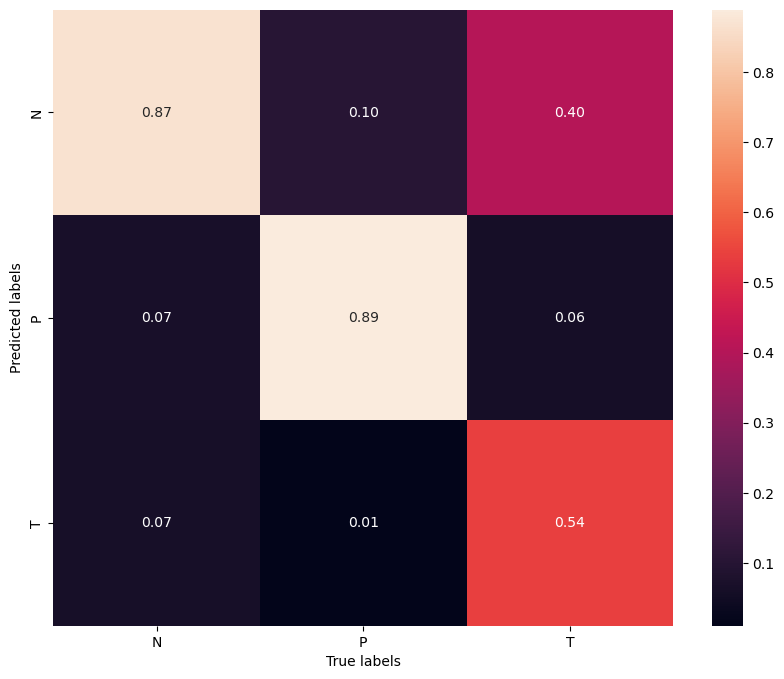

In [30]:
#with normalization-SVC
# Compute the confusion matrix
cm = confusion_matrix(test_labels, svc_pred)
cm_rel = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Compute the classification metrics
accuracy = accuracy_score(test_labels, svc_pred)
precision = precision_score(test_labels, svc_pred, average='macro')
recall = recall_score(test_labels, svc_pred, average='macro')
f1 = f1_score(test_labels,svc_pred, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
label_names = {
    0: "N",
    1: "P",
    2: "T"
}
label_classes = label_names.values()

plt.figure(figsize=(10,8))
sns.heatmap(cm_rel.T, xticklabels=label_classes, yticklabels=label_classes, annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# generate the classification report
print(classification_report(test_labels, svc_pred, target_names=['Normal', 'Pneumonia', 'Tuberculosis']))

              precision    recall  f1-score   support

      Normal       0.87      0.87      0.87      1319
   Pneumonia       0.83      0.89      0.86       577
Tuberculosis       0.61      0.54      0.57       263

    accuracy                           0.83      2159
   macro avg       0.77      0.76      0.77      2159
weighted avg       0.83      0.83      0.83      2159



Accuracy: 0.8597
Precision: 0.8492
Recall: 0.7569
F1: 0.7803


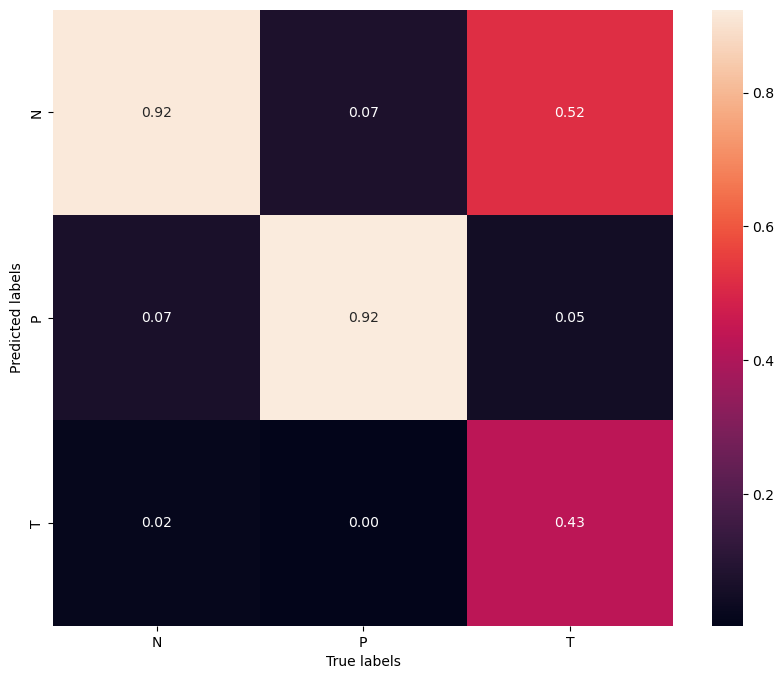

In [32]:
#with normalization-XGB
# Compute the confusion matrix
cm = confusion_matrix(test_labels, xgb_pred)
cm_rel = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Compute the classification metrics
accuracy = accuracy_score(test_labels, xgb_pred)
precision = precision_score(test_labels, xgb_pred, average='macro')
recall = recall_score(test_labels, xgb_pred, average='macro')
f1 = f1_score(test_labels,xgb_pred, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
label_names = {
    0: "N",
    1: "P",
    2: "T"
}
label_classes = label_names.values()

plt.figure(figsize=(10,8))
sns.heatmap(cm_rel.T, xticklabels=label_classes, yticklabels=label_classes, annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# generate the classification report
print(classification_report(test_labels, xgb_pred, target_names=['Normal', 'Pneumonia', 'Tuberculosis']))

              precision    recall  f1-score   support

      Normal       0.87      0.92      0.89      1319
   Pneumonia       0.84      0.92      0.88       577
Tuberculosis       0.84      0.43      0.57       263

    accuracy                           0.86      2159
   macro avg       0.85      0.76      0.78      2159
weighted avg       0.86      0.86      0.85      2159



In [ ]:
# Let's now use shapley values to explain the predictions

import shap
explainer = shap.KernelExplainer(svc_model.predict_proba, test_features, link="logit", algorithm="auto", n_samples=100)

# Step 5: Compute SHAP values using the kmeans approximation
shap_values = explainer.shap_values(test_features, l1_reg="num_features(10)")

# Step 6: Visualize SHAP values
shap.summary_plot(shap_values, test_features, plot_type="bar")
# Compute SHAP values for a test sample
#shap_values = explainer.shap_values(test_features[0])



In [ ]:
#np.array(shap_values).shape ,shap_values[0].shape, features.shape

In [ ]:
#test_features[0].shape